In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from numba import jit
import plotly_express as px
from itertools import combinations,permutations,product,combinations_with_replacement
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import findspark
from statsmodels.tsa.stattools import acf,pacf
from scipy.signal import find_peaks
import statsmodels.api as sm
import pickle
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data')

## all unique stock ids in book data
# same stocks are also in trade data 
subset_paths = glob.glob('book_train.parquet/stock_id=*')
unique_stocks_id = []
for path in subset_paths:
    unique_stocks_id.append(int(path.split('=')[1]))

unique_stocks_id = np.sort(np.array(unique_stocks_id))
print('total # stocks: ',len(unique_stocks_id))
unique_stocks_id



#train = pd.read_csv('c:/Finance_projects/Optiver-Realized-Volatility-Prediction/data/train.csv')

train = pd.read_csv('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/train.csv')

all_uniq_time_ids = pd.DataFrame({'time_id':train['time_id'].unique()})


total # stocks:  112


In [2]:
## SET PARAMETERS HERE for book_train.parquet files ONLY!!
## set the level (1 or 2) of the book data to use and Correlation method

level = 2 # set level 1 or 2 for book_train data
corr_method = 'pearson' # set 'pearson' or 'spearman'
file = 'book_train'


bid_price = "bid_price"+str(level)
ask_price = "ask_price"+str(level)
bid_size = "bid_size"+str(level)
ask_size = "ask_size"+str(level)

In [3]:
## give a dataframe with two columns to plot scatter and return correlation coefficient, x axis is column 1 and y axis is column 2
def plot_scatter_n_correlation(df,st_id,method='pearson'):
    corr = df.corr(method=method)
    corr_coef = corr[corr.columns[0]][1] # convert from matrix to single number
    fig = px.scatter(df,x=df.columns[0],y=df.columns[1])
    fig.update_traces(textposition='top center')

    fig.update_layout(
        height=400,width=700,
        title_text='scatter plot, stock id: '+str(st_id)+ '. Correlation coef: '+ str(corr_coef) + ' method: '+method,
    )
    #fig.show()  # enable/disable plot

    return corr_coef

In [4]:
def my_func(bid_size, bid_price):
    return bid_size.corr(bid_price)

In [5]:
def my_range_price(series):
    return series.max()-series.min()

In [6]:
def my_sum_abs_diff(series):
    return np.sum(np.abs(series.diff()))

In [7]:
columns = [bid_size,bid_price,ask_size,ask_price]

def all_pairs_of_columns_list(columns):
    return list(combinations(columns, 2))



In [9]:
## 7a) - 7e) Check if minimum/maximum/range of bidsize1/bid_price1 and asksize1/ask_price1 in a time_id correlated with target realized volatitlity for the same time_id?

train_target = pd.read_csv('train.csv')

subset_paths = glob.glob(file+'.parquet/stock_id=*')

min_bid_price_n_target_vol_corr_coef = {}
max_bid_price_n_target_vol_corr_coef = {}
min_ask_price_n_target_vol_corr_coef = {}
max_ask_price_n_target_vol_corr_coef = {}
min_bid_size_n_target_vol_corr_coef = {}
max_bid_size_n_target_vol_corr_coef = {}
min_ask_size_n_target_vol_corr_coef = {}
max_ask_size_n_target_vol_corr_coef = {}
range_ask_price_n_target_vol_corr_coef = {}
range_bid_price_n_target_vol_corr_coef = {}
range_ask_size_n_target_vol_corr_coef = {}
range_bid_size_n_target_vol_corr_coef = {}


bk_price_size_min_max_range = {}

bk_price_size_min_max_range['st_min_max_bid_price'+str(level)] = pd.DataFrame()
bk_price_size_min_max_range['st_min_max_ask_price'+str(level)] = pd.DataFrame()
bk_price_size_min_max_range['st_min_max_bid_size'+str(level)] = pd.DataFrame()
bk_price_size_min_max_range['st_min_max_ask_size'+str(level)] = pd.DataFrame()
bk_price_size_min_max_range['st_range_ask_price'+str(level)] = pd.DataFrame()
bk_price_size_min_max_range['st_range_bid_price'+str(level)] = pd.DataFrame()
bk_price_size_min_max_range['st_range_ask_size'+str(level)] = pd.DataFrame()
bk_price_size_min_max_range['st_range_bid_size'+str(level)] = pd.DataFrame()


for path in subset_paths:
    st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
    #st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        book_train_st = pd.read_parquet(path)

        st_min_max_bid_price = book_train_st.groupby(by='time_id')[bid_price].agg(['min','max']).rename(columns={'min':'min_bid_price','max':'max_bid_price'})
        common_time_id_mmbp = np.intersect1d(st_min_max_bid_price.index.values, target_st['time_id'].values) # ensure that only common time ids in trade_train and target are used.
        min_bid_price_n_target_vol_df = pd.DataFrame({'min_bid_price':st_min_max_bid_price.loc[common_time_id_mmbp,"min_bid_price"].values , 'target_vol':target_st.loc[common_time_id_mmbp,"target"].values})
        corr_coef_min_bid_price = plot_scatter_n_correlation(min_bid_price_n_target_vol_df,st_id,method=corr_method)
        min_bid_price_n_target_vol_corr_coef[st_id] = corr_coef_min_bid_price
        max_bid_price_n_target_vol_df = pd.DataFrame({'max_bid_price':st_min_max_bid_price.loc[common_time_id_mmbp,"max_bid_price"].values , 'target_vol':target_st.loc[common_time_id_mmbp,"target"].values})
        corr_coef_max_bid_price = plot_scatter_n_correlation(max_bid_price_n_target_vol_df,st_id,method=corr_method)
        max_bid_price_n_target_vol_corr_coef[st_id] = corr_coef_max_bid_price
        bk_price_size_min_max_range['st_min_max_bid_price'+str(level)] = pd.concat([ bk_price_size_min_max_range['st_min_max_bid_price'+str(level)], st_min_max_bid_price.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)


        st_min_max_ask_price = book_train_st.groupby(by='time_id')[ask_price].agg(['min','max']).rename(columns={'min':'min_ask_price','max':'max_ask_price'})
        common_time_id_mmap = np.intersect1d(st_min_max_ask_price.index.values, target_st['time_id'].values)
        min_ask_price_n_target_vol_df = pd.DataFrame({'min_ask_price':st_min_max_ask_price.loc[common_time_id_mmap,"min_ask_price"].values , 'target_vol':target_st.loc[common_time_id_mmap,"target"].values})
        corr_coef_min_ask_price = plot_scatter_n_correlation(min_ask_price_n_target_vol_df,st_id,method=corr_method)
        min_ask_price_n_target_vol_corr_coef[st_id] = corr_coef_min_ask_price
        max_ask_price_n_target_vol_df = pd.DataFrame({'max_ask_price':st_min_max_ask_price.loc[common_time_id_mmap,"max_ask_price"].values , 'target_vol':target_st.loc[common_time_id_mmap,"target"].values})
        corr_coef_max_ask_price = plot_scatter_n_correlation(max_ask_price_n_target_vol_df,st_id,method=corr_method)
        max_ask_price_n_target_vol_corr_coef[st_id] = corr_coef_max_ask_price
        bk_price_size_min_max_range['st_min_max_ask_price'+str(level)] = pd.concat([ bk_price_size_min_max_range['st_min_max_ask_price'+str(level)], st_min_max_ask_price.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_min_max_bid_size = book_train_st.groupby(by='time_id')[bid_size].agg(['min','max']).rename(columns={'min':'min_bid_size','max':'max_bid_size'})
        common_time_id_mmbz = np.intersect1d(st_min_max_bid_size.index.values, target_st['time_id'].values)
        min_bid_size_n_target_vol_df = pd.DataFrame({'min_bid_size':st_min_max_bid_size.loc[common_time_id_mmbz,"min_bid_size"].values , 'target_vol':target_st.loc[common_time_id_mmbz,"target"].values})
        corr_coef_min_bid_size = plot_scatter_n_correlation(min_bid_size_n_target_vol_df,st_id,method=corr_method)
        min_bid_size_n_target_vol_corr_coef[st_id] = corr_coef_min_bid_size
        max_bid_size_n_target_vol_df = pd.DataFrame({'max_bid_size':st_min_max_bid_size.loc[common_time_id_mmbz,"max_bid_size"].values , 'target_vol':target_st.loc[common_time_id_mmbz,"target"].values})
        corr_coef_max_bid_size = plot_scatter_n_correlation(max_bid_size_n_target_vol_df,st_id,method=corr_method)
        max_bid_size_n_target_vol_corr_coef[st_id] = corr_coef_max_bid_size
        bk_price_size_min_max_range['st_min_max_bid_size'+str(level)] = pd.concat([ bk_price_size_min_max_range['st_min_max_bid_size'+str(level)], st_min_max_bid_size.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_min_max_ask_size = book_train_st.groupby(by='time_id')[ask_size].agg(['min','max']).rename(columns={'min':'min_ask_size','max':'max_ask_size'})
        common_time_id_mmas = np.intersect1d(st_min_max_ask_size.index.values, target_st['time_id'].values)
        min_ask_size_n_target_vol_df = pd.DataFrame({'min_ask_size':st_min_max_ask_size.loc[common_time_id_mmas,"min_ask_size"].values , 'target_vol':target_st.loc[common_time_id_mmas,"target"].values})
        corr_coef_min_ask_size = plot_scatter_n_correlation(min_ask_size_n_target_vol_df,st_id,method=corr_method)
        min_ask_size_n_target_vol_corr_coef[st_id] = corr_coef_min_ask_size
        max_ask_size_n_target_vol_df = pd.DataFrame({'max_ask_size':st_min_max_ask_size.loc[common_time_id_mmas,"max_ask_size"].values , 'target_vol':target_st.loc[common_time_id_mmas,"target"].values})
        corr_coef_max_ask_size = plot_scatter_n_correlation(max_ask_size_n_target_vol_df,st_id,method=corr_method)
        max_ask_size_n_target_vol_corr_coef[st_id] = corr_coef_max_ask_size
        bk_price_size_min_max_range['st_min_max_ask_size'+str(level)] = pd.concat([ bk_price_size_min_max_range['st_min_max_ask_size'+str(level)], st_min_max_ask_size.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_range_ask_price = book_train_st.groupby(by='time_id').agg({ask_price:[my_range_price]}).rename(columns={ask_price:'range_ask_price'})
        st_range_ask_price.columns = st_range_ask_price.columns.droplevel(1)
        common_time_id_rap = np.intersect1d(st_range_ask_price.index.values, target_st['time_id'].values)
        range_ask_price_n_target_vol_df = pd.DataFrame({'range_ask_price':st_range_ask_price.loc[common_time_id_rap,"range_ask_price"].values , 'target_vol':target_st.loc[common_time_id_rap,"target"].values})
        corr_coef_range_ask_price = plot_scatter_n_correlation(range_ask_price_n_target_vol_df,st_id,method=corr_method)
        range_ask_price_n_target_vol_corr_coef[st_id] = corr_coef_range_ask_price
        bk_price_size_min_max_range['st_range_ask_price'+str(level)] = pd.concat([ bk_price_size_min_max_range['st_range_ask_price'+str(level)], st_range_ask_price.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_range_bid_price = book_train_st.groupby(by='time_id').agg({bid_price:[my_range_price]}).rename(columns={bid_price:'range_bid_price'})
        st_range_bid_price.columns = st_range_bid_price.columns.droplevel(1)
        common_time_id_rbp = np.intersect1d(st_range_bid_price.index.values, target_st['time_id'].values)
        range_bid_price_n_target_vol_df = pd.DataFrame({'range_bid_price':st_range_bid_price.loc[common_time_id_rbp,"range_bid_price"].values , 'target_vol':target_st.loc[common_time_id_rbp,"target"].values})
        corr_coef_range_bid_price = plot_scatter_n_correlation(range_bid_price_n_target_vol_df,st_id,method=corr_method)
        range_bid_price_n_target_vol_corr_coef[st_id] = corr_coef_range_bid_price
        bk_price_size_min_max_range['st_range_bid_price'+str(level)] = pd.concat([ bk_price_size_min_max_range['st_range_bid_price'+str(level)], st_range_bid_price.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_range_ask_size = book_train_st.groupby(by='time_id').agg({ask_size:[my_range_price]}).rename(columns={ask_size:'range_ask_size'})
        st_range_ask_size.columns = st_range_ask_size.columns.droplevel(1)
        common_time_id_ras = np.intersect1d(st_range_ask_size.index.values, target_st['time_id'].values)
        range_ask_size_n_target_vol_df = pd.DataFrame({'range_ask_size':st_range_ask_size.loc[common_time_id_ras,"range_ask_size"].values , 'target_vol':target_st.loc[common_time_id_ras,"target"].values})
        corr_coef_range_ask_size = plot_scatter_n_correlation(range_ask_size_n_target_vol_df,st_id,method=corr_method)
        range_ask_size_n_target_vol_corr_coef[st_id] = corr_coef_range_ask_size
        bk_price_size_min_max_range['st_range_ask_size'+str(level)] = pd.concat([ bk_price_size_min_max_range['st_range_ask_size'+str(level)], st_range_ask_size.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_range_bid_size = book_train_st.groupby(by='time_id').agg({bid_size:[my_range_price]}).rename(columns={bid_size:'range_bid_size'})
        st_range_bid_size.columns = st_range_bid_size.columns.droplevel(1)
        common_time_id_rbs = np.intersect1d(st_range_bid_size.index.values, target_st['time_id'].values)
        range_bid_size_n_target_vol_df = pd.DataFrame({'range_bid_size':st_range_bid_size.loc[common_time_id_rbs,"range_bid_size"].values , 'target_vol':target_st.loc[common_time_id_rbs,"target"].values})
        corr_coef_range_bid_size = plot_scatter_n_correlation(range_bid_size_n_target_vol_df,st_id,method=corr_method)
        range_bid_size_n_target_vol_corr_coef[st_id] = corr_coef_range_bid_size
        bk_price_size_min_max_range['st_range_bid_size'+str(level)] = pd.concat([ bk_price_size_min_max_range['st_range_bid_size'+str(level)], st_range_bid_size.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)




In [10]:
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/liquidity_features')

with open('bk_price_size_min_max_range_'+str(level)+'.pkl', 'wb') as f1:
    pickle.dump(bk_price_size_min_max_range, f1)
    print('saved bk_price_size_min_max_range_'+str(level)+'.pkl successfully')

saved bk_price_size_min_max_range_2.pkl successfully


In [12]:
## plot all stocks min_bid_price correlation vs. target 
coef_df=pd.DataFrame({'stock_id':min_bid_price_n_target_vol_corr_coef.keys(),'correlation_coef':min_bid_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(min_bid_price_n_target_vol_df.columns[0]) + " and " + str(min_bid_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks max_bid_price correlation vs. target 
coef_df=pd.DataFrame({'stock_id':max_bid_price_n_target_vol_corr_coef.keys(),'correlation_coef':max_bid_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(max_bid_price_n_target_vol_df.columns[0]) + " and " + str(max_bid_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()


## plot all stocks min_ask_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_ask_price_n_target_vol_corr_coef.keys(),'correlation_coef':min_ask_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(min_ask_price_n_target_vol_df.columns[0]) + " and " + str(min_ask_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks max_ask_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_ask_price_n_target_vol_corr_coef.keys(),'correlation_coef':max_ask_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(max_ask_price_n_target_vol_df.columns[0]) + " and " + str(max_ask_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks min_bid_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_bid_size_n_target_vol_corr_coef.keys(),'correlation_coef':min_bid_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(min_bid_size_n_target_vol_df.columns[0]) + " and " + str(min_bid_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks max_bid_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_bid_size_n_target_vol_corr_coef.keys(),'correlation_coef':max_bid_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(max_bid_size_n_target_vol_df.columns[0]) + " and " + str(max_bid_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks min_ask_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_ask_size_n_target_vol_corr_coef.keys(),'correlation_coef':min_ask_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(min_ask_size_n_target_vol_df.columns[0]) + " and " + str(min_ask_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks max_ask_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_ask_size_n_target_vol_corr_coef.keys(),'correlation_coef':max_ask_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(max_ask_size_n_target_vol_df.columns[0]) + " and " + str(max_ask_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks range_ask_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_ask_price_n_target_vol_corr_coef.keys(),'correlation_coef':range_ask_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(range_ask_price_n_target_vol_df.columns[0]) + " and " + str(range_ask_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks range_bid_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_bid_price_n_target_vol_corr_coef.keys(),'correlation_coef':range_bid_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(range_bid_price_n_target_vol_df.columns[0]) + " and " + str(range_bid_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks range_ask_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_ask_size_n_target_vol_corr_coef.keys(),'correlation_coef':range_ask_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(range_ask_size_n_target_vol_df.columns[0]) + " and " + str(range_ask_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks range_bid_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_bid_size_n_target_vol_corr_coef.keys(),'correlation_coef':range_bid_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(range_bid_size_n_target_vol_df.columns[0]) + " and " + str(range_bid_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()


In [11]:
## 7f) - 7i) Check if  the sum of absolute differences is correlated with target

os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data')
subset_paths = glob.glob(file+'.parquet/stock_id=*')

sum_abs_dif_ask_price_n_target_vol_corr_coef = {}
sum_abs_dif_ask_size_n_target_vol_corr_coef = {}
sum_abs_dif_bid_price_n_target_vol_corr_coef = {}
sum_abs_dif_bid_size_n_target_vol_corr_coef = {}

bk_price_size_sad = {}

bk_price_size_sad['st_sad_ask_price'+str(level)] = pd.DataFrame()
bk_price_size_sad['st_sad_ask_size'+str(level)] = pd.DataFrame()
bk_price_size_sad['st_sad_bid_price'+str(level)] = pd.DataFrame()
bk_price_size_sad['st_sad_bid_size'+str(level)] = pd.DataFrame()


for path in subset_paths:
    st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
    #st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        book_train_st = pd.read_parquet(path)

        st_sad_ask_price = book_train_st.groupby(by='time_id').agg({ask_price:[my_sum_abs_diff]}).rename(columns={ask_price:'sad_ask_price'})
        st_sad_ask_price.columns = st_sad_ask_price.columns.droplevel(1)
        common_time_id_sadap = np.intersect1d(st_sad_ask_price.index.values, target_st['time_id'].values)
        sad_ask_price_n_target_vol_df = pd.DataFrame({'sad_ask_price':st_sad_ask_price.loc[common_time_id_sadap,"sad_ask_price"].values , 'target_vol':target_st.loc[common_time_id_sadap,"target"].values})
        corr_coef_sad_ask_price = plot_scatter_n_correlation(sad_ask_price_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_ask_price_n_target_vol_corr_coef[st_id] = corr_coef_sad_ask_price
        bk_price_size_sad['st_sad_ask_price'+str(level)] = pd.concat([ bk_price_size_sad['st_sad_ask_price'+str(level)], st_sad_ask_price.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_sad_ask_size = book_train_st.groupby(by='time_id').agg({ask_size:[my_sum_abs_diff]}).rename(columns={ask_size:'sad_ask_size'})
        st_sad_ask_size.columns = st_sad_ask_size.columns.droplevel(1)
        common_time_id_sadas = np.intersect1d(st_sad_ask_size.index.values, target_st['time_id'].values)
        sad_ask_size_n_target_vol_df = pd.DataFrame({'sad_ask_size':st_sad_ask_size.loc[common_time_id_sadas,"sad_ask_size"].values , 'target_vol':target_st.loc[common_time_id_sadas,"target"].values})
        corr_coef_sad_ask_size = plot_scatter_n_correlation(sad_ask_size_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_ask_size_n_target_vol_corr_coef[st_id] = corr_coef_sad_ask_size
        bk_price_size_sad['st_sad_ask_size'+str(level)] = pd.concat([ bk_price_size_sad['st_sad_ask_size'+str(level)], st_sad_ask_size.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_sad_bid_price = book_train_st.groupby(by='time_id').agg({bid_price:[my_sum_abs_diff]}).rename(columns={bid_price:'sad_bid_price'})
        st_sad_bid_price.columns = st_sad_bid_price.columns.droplevel(1)
        common_time_id_sadbp = np.intersect1d(st_sad_bid_price.index.values, target_st['time_id'].values)
        sad_bid_price_n_target_vol_df = pd.DataFrame({'sad_bid_price':st_sad_bid_price.loc[common_time_id_sadbp,"sad_bid_price"].values , 'target_vol':target_st.loc[common_time_id_sadbp,"target"].values})
        corr_coef_sad_bid_price = plot_scatter_n_correlation(sad_bid_price_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_bid_price_n_target_vol_corr_coef[st_id] = corr_coef_sad_bid_price
        bk_price_size_sad['st_sad_bid_price'+str(level)] = pd.concat([ bk_price_size_sad['st_sad_bid_price'+str(level)], st_sad_bid_price.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_sad_bid_size = book_train_st.groupby(by='time_id').agg({bid_size:[my_sum_abs_diff]}).rename(columns={bid_size:'sad_bid_size'})
        st_sad_bid_size.columns = st_sad_bid_size.columns.droplevel(1)
        common_time_id_sadbs = np.intersect1d(st_sad_bid_size.index.values, target_st['time_id'].values)
        sad_bid_size_n_target_vol_df = pd.DataFrame({'sad_bid_size':st_sad_bid_size.loc[common_time_id_sadbs,"sad_bid_size"].values , 'target_vol':target_st.loc[common_time_id_sadbs,"target"].values})
        corr_coef_sad_bid_size = plot_scatter_n_correlation(sad_bid_size_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_bid_size_n_target_vol_corr_coef[st_id] = corr_coef_sad_bid_size
        bk_price_size_sad['st_sad_bid_size'+str(level)] = pd.concat([ bk_price_size_sad['st_sad_bid_size'+str(level)], st_sad_bid_size.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)


In [12]:
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/liquidity_features')

with open('bk_price_size_sad_'+str(level)+'.pkl', 'wb') as f1:
    pickle.dump(bk_price_size_sad, f1)
    print('saved bk_price_size_sad_'+str(level)+'.pkl successfully')

saved bk_price_size_sad_2.pkl successfully


In [ ]:
## plot all stocks sum_abs_dif_ask_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_ask_price_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_ask_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(sad_ask_price_n_target_vol_df.columns[0]) + " and " + str(sad_ask_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks sum_abs_dif_ask_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_ask_size_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_ask_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(sad_ask_size_n_target_vol_df.columns[0]) + " and " + str(sad_ask_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks sum_abs_dif_bid_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_bid_price_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_bid_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(sad_bid_price_n_target_vol_df.columns[0]) + " and " + str(sad_bid_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks sum_abs_dif_bid_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_bid_size_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_bid_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(sad_bid_size_n_target_vol_df.columns[0]) + " and " + str(sad_bid_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()




In [13]:
## 7g) - 7j) Check if the correlation of any pair of bidsize1,bid_price1,asksize1,ask_price1 is correlated with target realized volatitlity for all the time_ids?

os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data')
train_target = pd.read_csv('train.csv')
subset_paths = glob.glob(file+'.parquet/stock_id=*')

bs_bp_corr_n_target_vol_corr_coef = {}
bs_as_corr_n_target_vol_corr_coef = {}
bs_ap_corr_n_target_vol_corr_coef = {}
bp_as_corr_n_target_vol_corr_coef = {}
bp_ap_corr_n_target_vol_corr_coef = {}
as_ap_corr_n_target_vol_corr_coef = {}

bk_size_price_corr = {}

bk_size_price_corr['st_bs_bp_corr'+str(level)] = pd.DataFrame()
bk_size_price_corr['st_bs_as_corr'+str(level)] = pd.DataFrame()
bk_size_price_corr['st_bs_ap_corr'+str(level)] = pd.DataFrame()
bk_size_price_corr['st_bp_as_corr'+str(level)] = pd.DataFrame()
bk_size_price_corr['st_bp_ap_corr'+str(level)] = pd.DataFrame()
bk_size_price_corr['st_as_ap_corr'+str(level)] = pd.DataFrame()


for path in subset_paths:
    st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
    #st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        book_train_st = pd.read_parquet(path)

        st_bs_bp_corr = book_train_st.groupby('time_id')[[bid_size, bid_price]].corr().iloc[0::2, -1]
        st_bs_bp_corr.index = st_bs_bp_corr.index.droplevel(1)
        common_time_id_bs_bp = np.intersect1d(st_bs_bp_corr.index.values, target_st['time_id'].values)
        bs_bp_corr_n_target_vol_df = pd.DataFrame({'bs_bp_corr':st_bs_bp_corr.loc[common_time_id_bs_bp].values , 'target_vol':target_st.loc[common_time_id_bs_bp,"target"].values})
        corr_coef_bs_bp = plot_scatter_n_correlation(bs_bp_corr_n_target_vol_df,st_id,method=corr_method)
        bs_bp_corr_n_target_vol_corr_coef[st_id] = corr_coef_bs_bp
        bk_size_price_corr['st_bs_bp_corr'+str(level)] = pd.concat([ bk_size_price_corr['st_bs_bp_corr'+str(level)], st_bs_bp_corr.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_bs_as_corr = book_train_st.groupby('time_id')[[bid_size, ask_size]].corr().iloc[0::2, -1]
        st_bs_as_corr.index = st_bs_as_corr.index.droplevel(1)
        common_time_id_bs_as = np.intersect1d(st_bs_as_corr.index.values, target_st['time_id'].values)
        bs_as_corr_n_target_vol_df = pd.DataFrame({'bs_as_corr':st_bs_as_corr.loc[common_time_id_bs_as].values , 'target_vol':target_st.loc[common_time_id_bs_as,"target"].values})
        corr_coef_bs_as = plot_scatter_n_correlation(bs_as_corr_n_target_vol_df,st_id,method=corr_method)
        bs_as_corr_n_target_vol_corr_coef[st_id] = corr_coef_bs_as
        bk_size_price_corr['st_bs_as_corr'+str(level)] = pd.concat([ bk_size_price_corr['st_bs_as_corr'+str(level)], st_bs_as_corr.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_bs_ap_corr = book_train_st.groupby('time_id')[[bid_size, ask_price]].corr().iloc[0::2, -1]
        st_bs_ap_corr.index = st_bs_ap_corr.index.droplevel(1)
        common_time_id_bs_ap = np.intersect1d(st_bs_ap_corr.index.values, target_st['time_id'].values)
        bs_ap_corr_n_target_vol_df = pd.DataFrame({'bs_ap_corr':st_bs_ap_corr.loc[common_time_id_bs_ap].values , 'target_vol':target_st.loc[common_time_id_bs_ap,"target"].values})
        corr_coef_bs_ap = plot_scatter_n_correlation(bs_ap_corr_n_target_vol_df,st_id,method=corr_method)
        bs_ap_corr_n_target_vol_corr_coef[st_id] = corr_coef_bs_ap
        bk_size_price_corr['st_bs_ap_corr'+str(level)] = pd.concat([ bk_size_price_corr['st_bs_ap_corr'+str(level)], st_bs_ap_corr.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_bp_as_corr = book_train_st.groupby('time_id')[[bid_price, ask_size]].corr().iloc[0::2, -1]
        st_bp_as_corr.index = st_bp_as_corr.index.droplevel(1)
        common_time_id_bp_as = np.intersect1d(st_bp_as_corr.index.values, target_st['time_id'].values)
        bp_as_corr_n_target_vol_df = pd.DataFrame({'bp_as_corr':st_bp_as_corr.loc[common_time_id_bp_as].values , 'target_vol':target_st.loc[common_time_id_bp_as,"target"].values})
        corr_coef_bp_as = plot_scatter_n_correlation(bp_as_corr_n_target_vol_df,st_id,method=corr_method)
        bp_as_corr_n_target_vol_corr_coef[st_id] = corr_coef_bp_as
        bk_size_price_corr['st_bp_as_corr'+str(level)] = pd.concat([ bk_size_price_corr['st_bp_as_corr'+str(level)], st_bp_as_corr.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_bp_ap_corr = book_train_st.groupby('time_id')[[bid_price, ask_price]].corr().iloc[0::2, -1]
        st_bp_ap_corr.index = st_bp_ap_corr.index.droplevel(1)
        common_time_id_bp_ap = np.intersect1d(st_bp_ap_corr.index.values, target_st['time_id'].values)
        bp_ap_corr_n_target_vol_df = pd.DataFrame({'bp_ap_corr':st_bp_ap_corr.loc[common_time_id_bp_ap].values , 'target_vol':target_st.loc[common_time_id_bp_ap,"target"].values})
        corr_coef_bp_ap = plot_scatter_n_correlation(bp_ap_corr_n_target_vol_df,st_id,method=corr_method)
        bp_ap_corr_n_target_vol_corr_coef[st_id] = corr_coef_bp_ap
        bk_size_price_corr['st_bp_ap_corr'+str(level)] = pd.concat([ bk_size_price_corr['st_bp_ap_corr'+str(level)], st_bp_ap_corr.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_as_ap_corr = book_train_st.groupby('time_id')[[ask_size, ask_price]].corr().iloc[0::2, -1]
        st_as_ap_corr.index = st_as_ap_corr.index.droplevel(1)
        common_time_id_as_ap = np.intersect1d(st_as_ap_corr.index.values, target_st['time_id'].values)
        as_ap_corr_n_target_vol_df = pd.DataFrame({'as_ap_corr':st_as_ap_corr.loc[common_time_id_as_ap].values , 'target_vol':target_st.loc[common_time_id_as_ap,"target"].values})
        corr_coef_as_ap = plot_scatter_n_correlation(as_ap_corr_n_target_vol_df,st_id,method=corr_method)
        as_ap_corr_n_target_vol_corr_coef[st_id] = corr_coef_as_ap
        bk_size_price_corr['st_as_ap_corr'+str(level)] = pd.concat([ bk_size_price_corr['st_as_ap_corr'+str(level)], st_as_ap_corr.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)




In [14]:
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/liquidity_features')

with open('bk_size_price_corr_'+str(level)+'.pkl', 'wb') as f1:
    pickle.dump(bk_size_price_corr, f1)
    print('saved bk_size_price_corr._'+str(level)+'.pkl successfully')

saved bk_size_price_corr._2.pkl successfully


In [ ]:
## plot all stocks bid_size and bid_price correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':bs_bp_corr_n_target_vol_corr_coef.keys(),'correlation_coef':bs_bp_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(bs_bp_corr_n_target_vol_df.columns[0]) + " and " + str(bs_bp_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks bid_size and ask_size correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':bs_as_corr_n_target_vol_corr_coef.keys(),'correlation_coef':bs_as_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(bs_as_corr_n_target_vol_df.columns[0]) + " and " + str(bs_as_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks bid_size and ask_price correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':bs_ap_corr_n_target_vol_corr_coef.keys(),'correlation_coef':bs_ap_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(bs_ap_corr_n_target_vol_df.columns[0]) + " and " + str(bs_ap_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks bid_price and ask_size correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':bp_as_corr_n_target_vol_corr_coef.keys(),'correlation_coef':bp_as_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(bp_as_corr_n_target_vol_df.columns[0]) + " and " + str(bp_as_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks bid_price and ask_price correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':bp_ap_corr_n_target_vol_corr_coef.keys(),'correlation_coef':bp_ap_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(bp_ap_corr_n_target_vol_df.columns[0]) + " and " + str(bp_ap_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks ask_size and ask_price correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':as_ap_corr_n_target_vol_corr_coef.keys(),'correlation_coef':as_ap_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(as_ap_corr_n_target_vol_df.columns[0]) + " and " + str(as_ap_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()



In [95]:
## SET PARAMETERS HERE for trade_train.parquet files ONLY!!
## set the Correlation method

corr_method = 'pearson' # set 'pearson' or 'spearman'
file = 'trade_train' # set 'book_train' or 'trade_train'

price = "price"
size = "size"
order_count = "order_count"

## 7a) - 7e) Check if minimum/maximum/range of bidsize1/bid_price1 and asksize1/ask_price1 in a time_id correlated with target realized volatitlity for the same time_id?

os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data')

train_target = pd.read_csv('train.csv')

subset_paths = glob.glob(file+'.parquet/stock_id=*')

min_price_n_target_vol_corr_coef = {}
max_price_n_target_vol_corr_coef = {}
min_size_n_target_vol_corr_coef = {}
max_size_n_target_vol_corr_coef = {}
min_order_count_n_target_vol_corr_coef = {}
max_order_count_n_target_vol_corr_coef = {}
range_price_n_target_vol_corr_coef = {}
range_size_n_target_vol_corr_coef = {}
range_order_count_n_target_vol_corr_coef = {}


trade_price_size_order_count_min_max_range = {}

trade_price_size_order_count_min_max_range['st_min_price'] = pd.DataFrame()
trade_price_size_order_count_min_max_range['st_max_price'] = pd.DataFrame()
#trade_price_size_order_count_min_max_range['st_min_size'] = pd.DataFrame()
trade_price_size_order_count_min_max_range['st_max_size'] = pd.DataFrame()
#trade_price_size_order_count_min_max_range['st_min_order_count'] = pd.DataFrame()
trade_price_size_order_count_min_max_range['st_max_order_count'] = pd.DataFrame()
trade_price_size_order_count_min_max_range['st_range_price'] = pd.DataFrame()
trade_price_size_order_count_min_max_range['st_range_size'] = pd.DataFrame()
trade_price_size_order_count_min_max_range['st_range_order_count'] = pd.DataFrame()


for path in subset_paths:
    st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
    #st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        trade_train_st = pd.read_parquet(path)

        st_min_max_price = trade_train_st.groupby(by='time_id')[price].agg(['min','max']).rename(columns={'min':'min_price','max':'max_price'})
        common_time_id_p = np.intersect1d(st_min_max_price.index.values, target_st['time_id'].values) # ensure that only common time ids in trade_train and target are used.
        min_price_n_target_vol_df = pd.DataFrame({'min_price':st_min_max_price.loc[common_time_id_p,"min_price"].values , 'target_vol':target_st.loc[common_time_id_p,"target"].values})
        corr_coef_min_price = plot_scatter_n_correlation(min_price_n_target_vol_df,st_id,method=corr_method)
        min_price_n_target_vol_corr_coef[st_id] = corr_coef_min_price
        max_price_n_target_vol_df = pd.DataFrame({'max_price':st_min_max_price.loc[common_time_id_p,"max_price"].values , 'target_vol':target_st.loc[common_time_id_p,"target"].values})
        corr_coef_max_price = plot_scatter_n_correlation(max_price_n_target_vol_df,st_id,method=corr_method)
        max_price_n_target_vol_corr_coef[st_id] = corr_coef_max_price
        trade_price_size_order_count_min_max_range['st_max_price'] = pd.concat([ trade_price_size_order_count_min_max_range['st_max_price'], st_min_max_price.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)
        trade_price_size_order_count_min_max_range['st_min_price'] = pd.concat([ trade_price_size_order_count_min_max_range['st_min_price'], st_min_max_price.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)         

        st_min_max_size = trade_train_st.groupby(by='time_id')[size].agg(['min','max']).rename(columns={'min':'min_size','max':'max_size'})
        common_time_id_s = np.intersect1d(st_min_max_size.index.values, target_st['time_id'].values)
        min_size_n_target_vol_df = pd.DataFrame({'min_size':st_min_max_size.loc[common_time_id_s,"min_size"].values , 'target_vol':target_st.loc[common_time_id_s,"target"].values})
        corr_coef_min_size = plot_scatter_n_correlation(min_size_n_target_vol_df,st_id,method=corr_method)
        min_size_n_target_vol_corr_coef[st_id] = corr_coef_min_size
        max_size_n_target_vol_df = pd.DataFrame({'max_size':st_min_max_size.loc[common_time_id_s,"max_size"].values , 'target_vol':target_st.loc[common_time_id_s,"target"].values})
        corr_coef_max_size = plot_scatter_n_correlation(max_size_n_target_vol_df,st_id,method=corr_method)
        max_size_n_target_vol_corr_coef[st_id] = corr_coef_max_size
        #trade_price_size_order_count_min_max_range['st_min_size'] = pd.concat([ trade_price_size_order_count_min_max_range['st_min_size'], st_min_max_size.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)
        trade_price_size_order_count_min_max_range['st_max_size'] = pd.concat([ trade_price_size_order_count_min_max_range['st_max_size'], st_min_max_size.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_min_max_order_count = trade_train_st.groupby(by='time_id')[order_count].agg(['min','max']).rename(columns={'min':'min_order_count','max':'max_order_count'})
        common_time_id_oc = np.intersect1d(st_min_max_order_count.index.values, target_st['time_id'].values)
        min_order_count_n_target_vol_df = pd.DataFrame({'min_order_count':st_min_max_order_count.loc[common_time_id_oc,"min_order_count"].values , 'target_vol':target_st.loc[common_time_id_oc,"target"].values})
        corr_coef_min_order_count = plot_scatter_n_correlation(min_order_count_n_target_vol_df,st_id,method=corr_method)
        min_order_count_n_target_vol_corr_coef[st_id] = corr_coef_min_order_count
        max_order_count_n_target_vol_df = pd.DataFrame({'max_order_count':st_min_max_order_count.loc[common_time_id_oc,"max_order_count"].values , 'target_vol':target_st.loc[common_time_id_oc,"target"].values})
        corr_coef_max_order_count = plot_scatter_n_correlation(max_order_count_n_target_vol_df,st_id,method=corr_method)
        max_order_count_n_target_vol_corr_coef[st_id] = corr_coef_max_order_count
        #trade_price_size_order_count_min_max_range['st_min_order_count'] = pd.concat([ trade_price_size_order_count_min_max_range['st_min_order_count'], st_min_max_order_count.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)
        trade_price_size_order_count_min_max_range['st_max_order_count'] = pd.concat([ trade_price_size_order_count_min_max_range['st_max_order_count'], st_min_max_order_count.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_range_price = trade_train_st.groupby(by='time_id').agg({price:[my_range_price]}).rename(columns={price:'range_price'})
        st_range_price.columns = st_range_price.columns.droplevel(1)
        common_time_id_rp = np.intersect1d(st_range_price.index.values, target_st['time_id'].values)
        range_price_n_target_vol_df = pd.DataFrame({'range_price':st_range_price.loc[common_time_id_rp,"range_price"].values , 'target_vol':target_st.loc[common_time_id_rp,"target"].values})
        corr_coef_range_price = plot_scatter_n_correlation(range_price_n_target_vol_df,st_id,method=corr_method)
        range_price_n_target_vol_corr_coef[st_id] = corr_coef_range_price
        trade_price_size_order_count_min_max_range['st_range_price'] = pd.concat([ trade_price_size_order_count_min_max_range['st_range_price'], st_range_price.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_range_size = trade_train_st.groupby(by='time_id').agg({size:[my_range_price]}).rename(columns={size:'range_size'})
        st_range_size.columns = st_range_size.columns.droplevel(1)
        common_time_id_rs = np.intersect1d(st_range_size.index.values, target_st['time_id'].values)
        range_size_n_target_vol_df = pd.DataFrame({'range_size':st_range_size.loc[common_time_id_rs,"range_size"].values , 'target_vol':target_st.loc[common_time_id_rs,"target"].values})
        corr_coef_range_size = plot_scatter_n_correlation(range_size_n_target_vol_df,st_id,method=corr_method)
        range_size_n_target_vol_corr_coef[st_id] = corr_coef_range_size
        trade_price_size_order_count_min_max_range['st_range_size'] = pd.concat([ trade_price_size_order_count_min_max_range['st_range_size'], st_range_size.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_range_order_count = trade_train_st.groupby(by='time_id').agg({order_count:[my_range_price]}).rename(columns={order_count:'range_order_count'})
        st_range_order_count.columns = st_range_order_count.columns.droplevel(1)
        common_time_id_roc = np.intersect1d(st_range_order_count.index.values, target_st['time_id'].values)
        range_order_count_n_target_vol_df = pd.DataFrame({'range_order_count':st_range_order_count.loc[common_time_id_roc,"range_order_count"].values , 'target_vol':target_st.loc[common_time_id_roc,"target"].values})
        corr_coef_range_order_count = plot_scatter_n_correlation(range_order_count_n_target_vol_df,st_id,method=corr_method)
        range_order_count_n_target_vol_corr_coef[st_id] = corr_coef_range_order_count
        trade_price_size_order_count_min_max_range['st_range_order_count'] = pd.concat([ trade_price_size_order_count_min_max_range['st_range_order_count'], st_range_order_count.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)
        
        

In [96]:
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/liquidity_features')

with open('trade_price_size_order_count_min_max_range.pkl', 'wb') as f1:
    pickle.dump(trade_price_size_order_count_min_max_range, f1)
    print('saved trade_price_size_order_count_min_max_range.pkl successfully')

saved trade_price_size_order_count_min_max_range.pkl successfully


In [234]:
## plot all stocks min_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_price_n_target_vol_corr_coef.keys(),'correlation_coef':min_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'min_price' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks max_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_price_n_target_vol_corr_coef.keys(),'correlation_coef':max_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'max_price' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks min_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_size_n_target_vol_corr_coef.keys(),'correlation_coef':min_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'min_size' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks max_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_size_n_target_vol_corr_coef.keys(),'correlation_coef':max_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'max_size' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks min_order_count correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':min_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'min_order_count' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks max_order_count correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':max_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'max_order_count' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks range_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_price_n_target_vol_corr_coef.keys(),'correlation_coef':range_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'range_price' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks range_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_size_n_target_vol_corr_coef.keys(),'correlation_coef':range_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'range_size' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks range_order_count correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':range_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'range_order_count' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()


In [50]:

os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data')

sum_abs_dif_price_n_target_vol_corr_coef = {}
sum_abs_dif_size_n_target_vol_corr_coef = {}
sum_abs_dif_order_count_n_target_vol_corr_coef = {}

trade_price_size_order_count_sad = {}

trade_price_size_order_count_sad['st_sad_price'] = pd.DataFrame()
trade_price_size_order_count_sad['st_sad_size'] = pd.DataFrame()
trade_price_size_order_count_sad['st_sad_order_count'] = pd.DataFrame()


for path in subset_paths:
    st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
    #st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        trade_train_st = pd.read_parquet(path)

        st_sad_price = trade_train_st.groupby(by='time_id').agg({price:[my_sum_abs_diff]}).rename(columns={price:'sad_price'})
        st_sad_price.columns = st_sad_price.columns.droplevel(1)
        common_time_id_sad_p = np.intersect1d(st_sad_price.index.values, target_st['time_id'].values)
        sad_price_n_target_vol_df = pd.DataFrame({'sad_price':st_sad_price.loc[common_time_id_sad_p,"sad_price"].values , 'target_vol':target_st.loc[common_time_id_sad_p,"target"].values})
        corr_coef_sad_price = plot_scatter_n_correlation(sad_price_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_price_n_target_vol_corr_coef[st_id] = corr_coef_sad_price
        trade_price_size_order_count_sad['st_sad_price'] = pd.concat([ trade_price_size_order_count_sad['st_sad_price'], st_sad_price.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_sad_size = trade_train_st.groupby(by='time_id').agg({size:[my_sum_abs_diff]}).rename(columns={size:'sad_size'})
        st_sad_size.columns = st_sad_size.columns.droplevel(1)
        common_time_id_sad_s = np.intersect1d(st_sad_size.index.values, target_st['time_id'].values)
        sad_size_n_target_vol_df = pd.DataFrame({'sad_size':st_sad_size.loc[common_time_id_sad_s,"sad_size"].values , 'target_vol':target_st.loc[common_time_id_sad_s,"target"].values})
        corr_coef_sad_size = plot_scatter_n_correlation(sad_size_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_size_n_target_vol_corr_coef[st_id] = corr_coef_sad_size
        trade_price_size_order_count_sad['st_sad_size'] = pd.concat([ trade_price_size_order_count_sad['st_sad_size'], st_sad_size.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_sad_order_count = trade_train_st.groupby(by='time_id').agg({order_count:[my_sum_abs_diff]}).rename(columns={order_count:'sad_order_count'})
        st_sad_order_count.columns = st_sad_order_count.columns.droplevel(1)
        common_time_id_sad_oc = np.intersect1d(st_sad_order_count.index.values, target_st['time_id'].values)
        sad_order_count_n_target_vol_df = pd.DataFrame({'sad_order_count':st_sad_order_count.loc[common_time_id_sad_oc,"sad_order_count"].values , 'target_vol':target_st.loc[common_time_id_sad_oc,"target"].values})
        corr_coef_sad_order_count = plot_scatter_n_correlation(sad_order_count_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_order_count_n_target_vol_corr_coef[st_id] = corr_coef_sad_order_count
        trade_price_size_order_count_sad['st_sad_order_count'] = pd.concat([ trade_price_size_order_count_sad['st_sad_order_count'], st_sad_order_count.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        


In [55]:
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/liquidity_features')

with open('trade_price_size_order_count_sad.pkl', 'wb') as f1:
    pickle.dump(trade_price_size_order_count_sad, f1)
    print('saved trade_price_size_order_count_sad.pkl successfully')

saved trade_price_size_order_count_sad.pkl successfully


In [237]:
## plot all stocks sum_abs_dif_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_price_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'sad_price' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()

## plot all stocks sum_abs_dif_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_size_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'sad_size' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()

## plot all stocks sum_abs_dif_order_count correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'sad_order_count' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()



In [93]:
## 7g) - 7j) Check if the correlation of any pair of bidsize1,bid_price1,asksize1,ask_price1 is correlated with target realized volatitlity for all the time_ids?

os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data')

price_size_corr_n_target_vol_corr_coef = {}
price_order_count_n_target_vol_corr_coef = {}
size_order_count_n_target_vol_corr_coef = {}

trade_price_size_order_count_corr = {}

#trade_price_size_order_count_corr['st_price_size_corr'] = pd.DataFrame()
#trade_price_size_order_count_corr['st_price_order_count_corr'] = pd.DataFrame()
trade_price_size_order_count_corr['st_size_order_count_corr'] = pd.DataFrame()

for path in subset_paths:
    st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
    #st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        trade_train_st = pd.read_parquet(path)

        st_price_size_corr = trade_train_st.groupby('time_id')[[price, size]].corr().iloc[0::2, -1]
        st_price_size_corr.index = st_price_size_corr.index.droplevel(1)
        common_time_id_price_size = np.intersect1d(st_price_size_corr.index.values, target_st['time_id'].values)
        price_size_corr_n_target_vol_df = pd.DataFrame({'price_size_corr':st_price_size_corr.loc[common_time_id_price_size].values , 'target_vol':target_st.loc[common_time_id_price_size,"target"].values})
        corr_coef_price_size = plot_scatter_n_correlation(price_size_corr_n_target_vol_df,st_id,method=corr_method)
        price_size_corr_n_target_vol_corr_coef[st_id] = corr_coef_price_size
        #trade_price_size_order_count_corr['st_price_size_corr'] = pd.concat([ trade_price_size_order_count_corr['st_price_size_corr'], st_price_size_corr.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_price_order_count_corr = trade_train_st.groupby('time_id')[[price, order_count]].corr().iloc[0::2, -1]
        st_price_order_count_corr.index = st_price_order_count_corr.index.droplevel(1)
        common_time_id_price_order_count = np.intersect1d(st_price_order_count_corr.index.values, target_st['time_id'].values)
        price_order_count_corr_n_target_vol_df = pd.DataFrame({'price_order_count_corr':st_price_order_count_corr.loc[common_time_id_price_order_count].values , 'target_vol':target_st.loc[common_time_id_price_order_count,"target"].values})
        corr_coef_price_order_count = plot_scatter_n_correlation(price_order_count_corr_n_target_vol_df,st_id,method=corr_method)
        price_order_count_n_target_vol_corr_coef[st_id] = corr_coef_price_order_count
        #trade_price_size_order_count_corr['st_price_order_count_corr'] = pd.concat([ trade_price_size_order_count_corr['st_price_order_count_corr'], st_price_order_count_corr.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)

        st_size_order_count_corr = trade_train_st.groupby('time_id')[[size, order_count]].corr().iloc[0::2, -1]
        st_size_order_count_corr.index = st_size_order_count_corr.index.droplevel(1)
        common_time_id_size_order_count = np.intersect1d(st_size_order_count_corr.index.values, target_st['time_id'].values)
        size_order_count_corr_n_target_vol_df = pd.DataFrame({'size_order_count_corr':st_size_order_count_corr.loc[common_time_id_size_order_count].values , 'target_vol':target_st.loc[common_time_id_size_order_count,"target"].values})
        corr_coef_size_order_count = plot_scatter_n_correlation(size_order_count_corr_n_target_vol_df,st_id,method=corr_method)
        size_order_count_n_target_vol_corr_coef[st_id] = corr_coef_size_order_count
        trade_price_size_order_count_corr['st_size_order_count_corr'] = pd.concat([ trade_price_size_order_count_corr['st_size_order_count_corr'], st_size_order_count_corr.reindex(target_st['time_id'].values).ffill().bfill() ],axis=0)
        

In [94]:
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/liquidity_features')

with open('trade_price_size_order_count_corr.pkl', 'wb') as f1:
    pickle.dump(trade_price_size_order_count_corr, f1)
    print('saved trade_price_size_order_count_corr.pkl successfully')


saved trade_price_size_order_count_corr.pkl successfully


In [239]:
## plot all stocks price and size correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':price_size_corr_n_target_vol_corr_coef.keys(),'correlation_coef':price_size_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'price_size_corr' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()

## plot all stocks price and order_count correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':price_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':price_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'price_order_count_corr' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()

## plot all stocks size and order_count correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':size_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':size_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'size_order_count_corr' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()


In [179]:
## 9) GARCH model to predict target volatility in 2nd 10 mins.
## create wap and log returns series in the first 10 mins.


def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return).values
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    stock_id = file_path.split('=')[1]
    df_book_data['row_id'] = df_book_data['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_book_data[['row_id','wap','log_return']]


def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_wap_log_rets = pd.DataFrame()
    for file in list_file:
        df_wap_log_rets = pd.concat([df_wap_log_rets,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_wap_log_rets

## following code should be run on GPU/CoLab not CPU. Takes too long on CPU.
# list_order_book_file_train = glob.glob('C:/Finance_projects/Optiver-Realized-Volatility-Prediction/data/book_train.parquet/*')

# df_wap_log_rets_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
#                                                            prediction_column_name='first_10_min_vol')

# df_wap_log_rets_train.to_parquet('wap_log_returns.parquet\\first_10_min_wap_log_returns.parquet')



In [62]:
## 9a) Extract wap and log returns series in the first 10 mins. for each stock from book and trade data
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/wap_log_returns.parquet')

# book_wap_log_returns_df =  pd.read_parquet('book_first_10_min_wap_log_returns.parquet')
# book_wap_log_returns_df['10e2x_log_return'] = book_wap_log_returns_df['log_return'].multiply(10e2)
# book_wap_log_returns_df['sqr_10e2x_log_return'] = book_wap_log_returns_df['10e2x_log_return'].pow(2)

# book_wap_log_returns_df['st_id'] = book_wap_log_returns_df['row_id'].apply(lambda x: int(x.split('-')[0]))
# book_wap_log_returns_df['time_id'] = book_wap_log_returns_df['row_id'].apply(lambda x: int(x.split('-')[1]))
# book_wap_log_returns_df = book_wap_log_returns_df.sort_values(by=['st_id','time_id'])
# book_wap_log_returns_df.to_parquet('book_wap_log_returns_df.parquet')

book_wap_log_returns_df = pd.read_parquet('book_wap_log_returns_df.parquet')
book_wap_log_returns_df


# trade_wap_log_returns_df =  pd.read_parquet('trade_first_10_min_wap_log_returns.parquet')
# trade_wap_log_returns_df['10e2x_log_return'] = trade_wap_log_returns_df['log_return'].multiply(10000)
# trade_wap_log_returns_df['sqr_10e2x_log_return'] = trade_wap_log_returns_df['10e2x_log_return'].pow(2)

# trade_wap_log_returns_df['st_id'] = trade_wap_log_returns_df['row_id'].apply(lambda x: int(x.split('-')[0]))
# trade_wap_log_returns_df['time_id'] = trade_wap_log_returns_df['row_id'].apply(lambda x: int(x.split('-')[1]))
# trade_wap_log_returns_df = trade_wap_log_returns_df.sort_values(by=['st_id','time_id'])
# trade_wap_log_returns_df
# trade_wap_log_returns_df.to_parquet('trade_wap_log_returns_df.parquet')

trade_wap_log_returns_df = pd.read_parquet('trade_wap_log_returns_df.parquet')
trade_wap_log_returns_df





## read in the wap and log returns series in the first 10 mins for all stocks and time_ids.

# book_wap_log_returns_df =  pd.read_parquet('wap_log_returns.parquet\\book_first_10_min_wap_log_returns.parquet')
# trade_wap_log_returns_df =  pd.read_parquet('wap_log_returns.parquet\\trade_first_10_min_wap_log_returns.parquet')

# book_wap_log_returns_df =  pd.read_parquet('wap_log_returns.parquet/book_first_10_min_wap_log_returns-001.parquet')
# trade_wap_log_returns_df =  pd.read_parquet('wap_log_returns.parquet/trade_first_10_min_wap_log_returns.parquet')

# book_wap_log_returns_df['log_return_sqr'] = book_wap_log_returns_df['log_return'].pow(2)
# trade_wap_log_returns_df['log_return_sqr'] = trade_wap_log_returns_df['log_return'].pow(2)

# book_wap_log_returns_df['10^6x_log_return_sqr'] = book_wap_log_returns_df['log_return_sqr'].multiply(10e6)
# trade_wap_log_returns_df['10^6x_log_return_sqr'] = trade_wap_log_returns_df['log_return_sqr'].multiply(10e6)
# book_wap_log_returns_df





,row_id,price,log_return,10e2x_log_return,sqr_10e2x_log_return,st_id,time_id
1,0-5,1.002778,0.000476,4.755103,22.611002,0,5
2,0-5,1.002818,0.000040,0.402993,0.162403,0,5
3,0-5,1.003155,0.000336,3.358822,11.281684,0,5
4,0-5,1.003646,0.000489,4.888836,23.900717,0,5
5,0-5,1.003762,0.000116,1.161564,1.349231,0,5
...,...,...,...,...,...,...,...
162266,126-32767,0.999949,-0.000195,-1.954346,3.819468,126,32767
162267,126-32767,0.999691,-0.000257,-2.571807,6.614193,126,32767
162268,126-32767,0.999640,-0.000051,-0.514560,0.264772,126,32767
162269,126-32767,0.999482,-0.000158,-1.582603,2.504631,126,32767


In [65]:
## 14) check if BOOK's wap's and log_return's max, min, mean, skew and kurtosis are correlated with target volatility
## using 10e2x_log_return instead of log_return to avoid very small numbers in the data. (numerical stability)

book_wap_log_return_stats_df = pd.DataFrame(columns=['st_id','time_id','wap_max','wap_min','wap_mean','wap_skew','wap_kurtosis','10e2x_log_return_min','10e2x_log_return_max','10e2x_log_return_mean','10e2x_log_return_skew','10e2x_log_return_kurtosis'])
book_wap_log_return_stats_df['st_id'] = book_wap_log_returns_df['st_id']
book_wap_log_return_stats_df['time_id'] = book_wap_log_returns_df['time_id']

book_wap_log_return_stats_df['wap_max'] = book_wap_log_returns_df.groupby(['st_id','time_id'])['wap'].max().values

# merge target volatiltiy column with wap_log_return_stats_df
book_wap_log_return_stats_df = book_wap_log_return_stats_df.merge(train_target[['stock_id','time_id','target']],how='inner',on=['stock_id','time_id'])


# find correlation beetween next_50sec_vol and target_vol
book_wap_log_return_stats_corr = book_wap_log_return_stats_df.groupby(['st_id'])[['wap_max', 'target']].corr().iloc[0::2, -1]






ValueError: Length of values (428932) does not match length of index (166824357)

In [ ]:
## plot all stocks wap_max correlation vs. correlation with target
fig = px.bar(book_wap_log_return_stats_corr, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'wap_max' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()


In [ ]:
## 14) check if TRADE's wap's and log_return's max, min, mean, skew and kurtosis are correlated with target volatility
## using 10e2x_log_return instead of log_return to avoid very small numbers in the data. (numerical stability)

trade_wap_log_return_stats_df = pd.DataFrame(columns=['st_id','time_id','wap_max','wap_min','wap_mean','wap_skew','wap_kurtosis','10e2x_log_return_min','10e2x_log_return_max','10e2x_log_return_mean','10e2x_log_return_skew','10e2x_log_return_kurtosis'])
trade_wap_log_return_stats_df['st_id'] = book_wap_log_returns_df['st_id']
trade_wap_log_return_stats_df['time_id'] = book_wap_log_returns_df['time_id']

trade_wap_log_return_stats_df['wap_max'] = book_wap_log_returns_df.groupby(['st_id','time_id'])['wap'].max().values

# merge target volatiltiy column with wap_log_return_stats_df
trade_wap_log_return_stats_df = trade_wap_log_return_stats_df.merge(train_target[['stock_id','time_id','target']],how='inner',on=['stock_id','time_id'])


# find correlation beetween next_50sec_vol and target_vol
trade_wap_log_return_stats_corr = trade_wap_log_return_stats_df.groupby(['st_id'])[['wap_max', 'target']].corr().iloc[0::2, -1]


In [ ]:
## plot all stocks wap_max correlation vs. correlation with target
fig = px.bar(trade_wap_log_return_stats_corr, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'wap_max' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()

In [60]:
def my_ewma_last_100(series):
    last_x_periods = 100
    return series.ewm(span=100,adjust=False).mean()[-last_x_periods:].sum()

def my_st_id_splitter(row_id):
    return int(str(row_id.values[0]).split('-')[0])

def my_time_id_splitter(row_id):
    return int(str(row_id.values[0]).split('-')[1])

In [77]:
# 8) EWMA of BOOK squared log returns for each stock_id

book_all_ewma_vol = pd.DataFrame()
book_all_ewma_vol['book_ewma_vol'] = book_wap_log_returns_df.groupby('row_id').agg({'sqr_10e2x_log_return':[my_ewma_last_100]}).values.flatten()
book_all_ewma_vol['st_id'] = book_wap_log_returns_df.groupby('row_id').agg({'row_id':[my_st_id_splitter]}).values.flatten()
book_all_ewma_vol['time_id'] = book_wap_log_returns_df.groupby('row_id').agg({'row_id':[my_time_id_splitter]}).values.flatten()
book_all_ewma_vol_sorted = book_all_ewma_vol.sort_values(by=['st_id', 'time_id']).reset_index(drop=True)
train.sort_values(by=['stock_id', 'time_id']).reset_index(drop=True)
book_all_ewma_vol_sorted['target'] = train['target']
ewma_vol_corr = book_all_ewma_vol_sorted.groupby('st_id')[['book_ewma_vol', 'target']].corr().iloc[0::2, -1]
ewma_vol_corr.index = ewma_vol_corr.index.droplevel(1)
book_all_ewma_vol_sorted

,book_ewma_vol,st_id,time_id,target
0,6.390281,0,5,0.004136
1,0.386390,0,11,0.001445
2,4.568490,0,16,0.002168
3,3.842125,0,31,0.002195
4,1.630398,0,62,0.001747
...,...,...,...,...
428927,5.352028,126,32751,0.003461
428928,7.540169,126,32753,0.003113
428929,4.188939,126,32758,0.004070
428930,3.259533,126,32763,0.003357


In [82]:
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/liquidity_features')

with open('bk_all_ewma_vol_sorted.pkl', 'wb') as f1:
    pickle.dump(book_all_ewma_vol_sorted['book_ewma_vol'], f1)
    print('saved bk_all_ewma_vol_sorted.pkl successfully')

saved bk_all_ewma_vol_sorted.pkl successfully


In [8]:
# 8) plot of EWMA of BOOK squared log returns correlation with target for each stock_id
ewma_vol_corr_df = pd.DataFrame({'stock_id': ewma_vol_corr.index, 'correlation_coef': ewma_vol_corr.values})
#ewma_vol_corr_df.plot(x='stock_id', y='correlation_coef', kind='bar', title='EWMA Volatility Correlation with target')
fig = px.bar(ewma_vol_corr_df, x='stock_id',y='correlation_coef',title="Correlation coef. between BOOK " + "ewma_vol" + " and " + "target"+" for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

In [79]:
# 8) EWMA of TRADE squared log returns for each stock_id


trade_all_ewma_vol = pd.DataFrame()
trade_all_ewma_vol['trade_ewma_vol'] = trade_wap_log_returns_df.groupby('row_id').agg({'sqr_10e2x_log_return':[my_ewma_last_100]}).values.flatten()
trade_all_ewma_vol['st_id'] = trade_wap_log_returns_df.groupby('row_id').agg({'row_id':[my_st_id_splitter]}).values.flatten()
trade_all_ewma_vol['time_id'] = trade_wap_log_returns_df.groupby('row_id').agg({'row_id':[my_time_id_splitter]}).values.flatten()
trade_all_ewma_vol_sorted = trade_all_ewma_vol.sort_values(by=['st_id', 'time_id']).reset_index(drop=True)
train.sort_values(by=['stock_id', 'time_id']).reset_index(drop=True)
trade_all_ewma_vol_sorted['target'] = train['target']
ewma_vol_corr = trade_all_ewma_vol_sorted.groupby('st_id')[['trade_ewma_vol', 'target']].corr().iloc[0::2, -1]
ewma_vol_corr.index = ewma_vol_corr.index.droplevel(1)
trade_all_ewma_vol_sorted

,trade_ewma_vol,st_id,time_id,target
0,743.439244,0,5,0.004136
1,43.230502,0,11,0.001445
2,716.387841,0,16,0.002168
3,36.186753,0,31,0.002195
4,111.008401,0,62,0.001747
...,...,...,...,...
428847,331.932937,126,32751,0.002788
428848,134.809890,126,32753,0.001769
428849,137.812375,126,32758,0.004185
428850,659.678332,126,32763,0.001991


In [83]:
merged = pd.merge(train,trade_all_ewma_vol_sorted, left_on=['stock_id','time_id'], right_on=['st_id','time_id'], how='left').ffill().bfill()
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/liquidity_features')

with open('trade_all_ewma_vol_sorted.pkl', 'wb') as f1:
    pickle.dump(merged['trade_ewma_vol'], f1)
    print('saved trade_all_ewma_vol_sorted.pkl successfully')

saved trade_all_ewma_vol_sorted.pkl successfully


In [67]:
# 8) plot of EWMA of TRADE squared log returns correlation with target for each stock_id
ewma_vol_corr_df = pd.DataFrame({'stock_id': ewma_vol_corr.index, 'correlation_coef': ewma_vol_corr.values})
#ewma_vol_corr_df.plot(x='stock_id', y='correlation_coef', kind='bar', title='EWMA Volatility Correlation with target')
fig = px.bar(ewma_vol_corr_df, x='stock_id',y='correlation_coef',title="Correlation coef. between TRADE " + "ewma_vol" + " and " + "target"+" for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

In [ ]:
def my_arch_func(series):
    
    all_models = {'log_likelihood':[],'comb':[],'sig_coef':[],'vol':[]}
    for comb in product([0,1,2],[1,2,3],[0,1,2]):
        model1 = arch_model(series, mean="Constant", vol="EGARCH", p=comb[0],o=comb[1], q=comb[2],dist='t' ,rescale=True)
        fitted_model1 = model1.fit(disp="off")
        all_models['log_likelihood'].append(fitted_model1.loglikelihood)
        all_models['comb'].append(comb)
        # Extract coefficients and p-values
        coefficients1 = fitted_model1.params
        p_values1 = fitted_model1.pvalues
        all_models['sig_coef'].append(coefficients1[:-1][p_values1 < 0.05]) # remove nu coeficient
        all_models['vol'].append('EGARCH')
        
        model2 = arch_model(series, mean="Constant", vol="GARCH", p=comb[0],o=comb[1], q=comb[2],dist='t' ,rescale=True)
        fitted_model2 = model2.fit(disp="off")
        all_models['log_likelihood'].append(fitted_model2.loglikelihood)
        all_models['comb'].append(comb)
        # Extract coefficients and p-values
        coefficients2 = fitted_model2.params
        p_values2 = fitted_model2.pvalues
        all_models['sig_coef'].append(coefficients2[:-1][p_values2 < 0.05]) # remove nu coeficient
        all_models['vol'].append('GARCH')

    for i in np.argsort(all_models['log_likelihood'])[::-1]:
        if (all_models['sig_coef'][i].shape[0] > 1):
            best_model_params = all_models['comb'][i]
            vol_model = all_models['vol'][i]
            break

    # best_model_params = None
    if best_model_params == None:
        best_model_params = (1,1,1)
        vol_model = 'EGARCH'
        print('\n\n BEST MODEL NOT FOUND. USING DEFAULT MODEL (1,1,1) EGARCH \n\n')

    model = arch_model(series, mean="Constant", vol=vol_model, p=best_model_params[0],o=best_model_params[1], q=best_model_params[2],dist='t' ,rescale=True)
    fitted_model = model.fit(disp="off")
    #fitted_model.summary()
    rescale_value = fitted_model.scale

    # fig = px.line(series.pow(2),title='test set (squared returns i.e. sqr_log_return)')
    # fig.show()

    forecasts = fitted_model.forecast(horizon=50,method='simulation')
    #print(forecasts.variance)
    #print(forecasts.variance.iloc[-1,:].values/(rescale_value**2))
    #forecasts.variance.iloc[-1,:].divide(rescale_value**2).plot(title='forecasted variance')

    return sum(forecasts.variance.iloc[-1,:].values/(rescale_value**2))







In [ ]:

## 9a) Use EGARCH or GJR-GARCH model to predict target volatility in first 50 seconds of 2nd 10 mins.

next_50sec_vol_df = pd.DataFrame(columns=['st_id','time_id','next_50sec_vol'])
next_50sec_vol_df['st_id'] = book_wap_log_returns_df['st_id']
next_50sec_vol_df['time_id'] = book_wap_log_returns_df['time_id']

next_50sec_vol_df['next_50sec_vol'] = np.array(book_wap_log_returns_df.groupby(['st_id','time_id']).agg({'log_return':[my_arch_func]})).flatten()
# perform min-max scaling on next_50sec_vol
next_50sec_vol_df['next_50sec_vol'] = (next_50sec_vol_df['next_50sec_vol'] - next_50sec_vol_df['next_50sec_vol'].min())/(next_50sec_vol_df['next_50sec_vol'].max() - next_50sec_vol_df['next_50sec_vol'].min())

# find correlation beetween next_50sec_vol and target_vol
next_50sec_vol_df = next_50sec_vol_df.merge(train_target[['stock_id','time_id','target']],how='inner',on=['stock_id','time_id'])
next_50sec_vol_df = next_50sec_vol_df.drop(columns=['st_id','time_id'])
corr_coef_next_50sec_vol = next_50sec_vol_df.corr(method=corr_method)


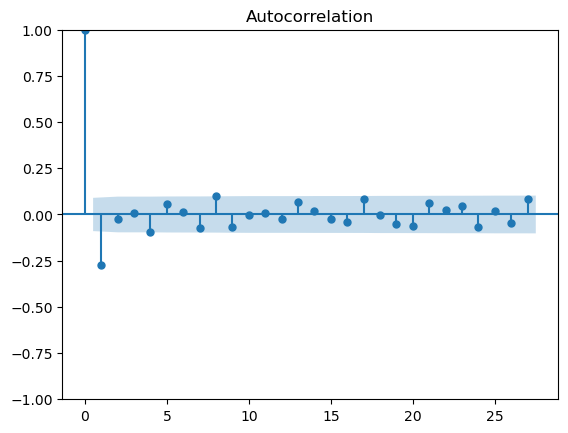

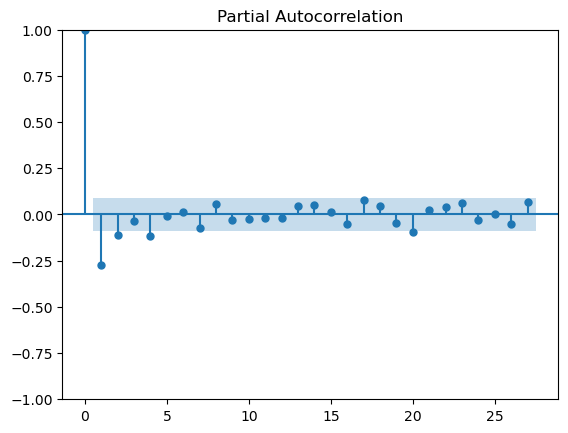

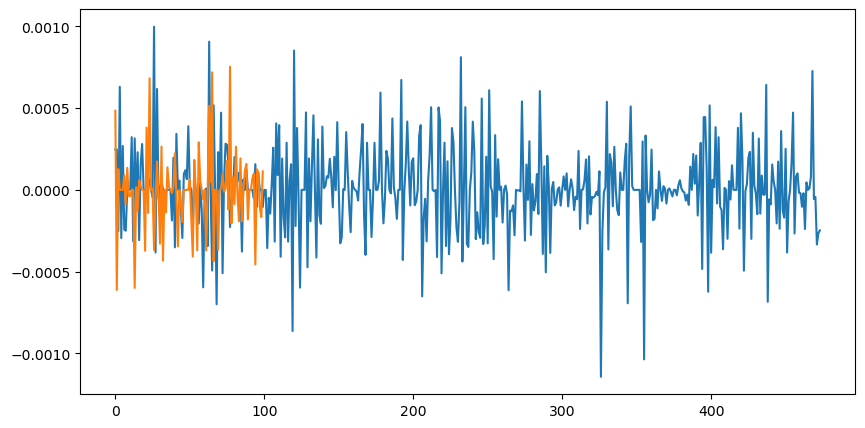

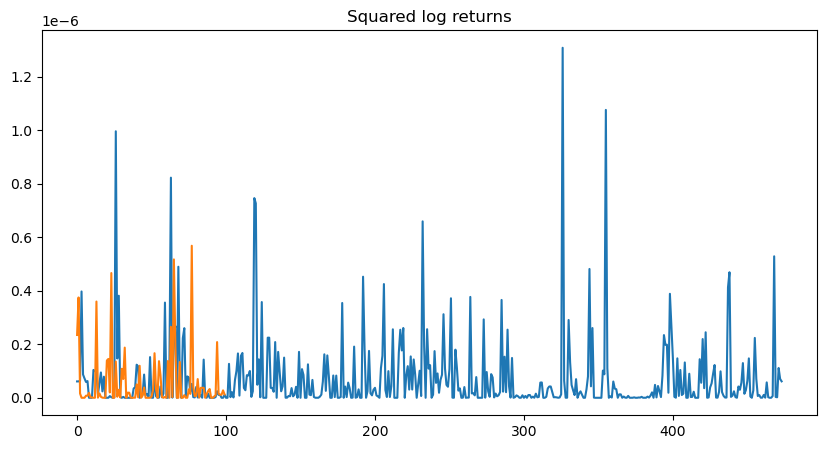

/home/optimusprime/miniconda3/envs/optiver_linux/lib/python3.10/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


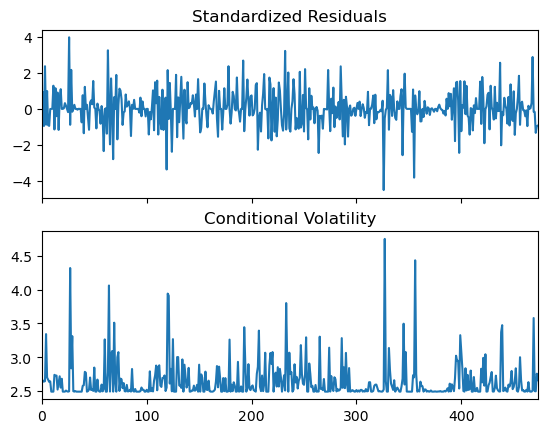

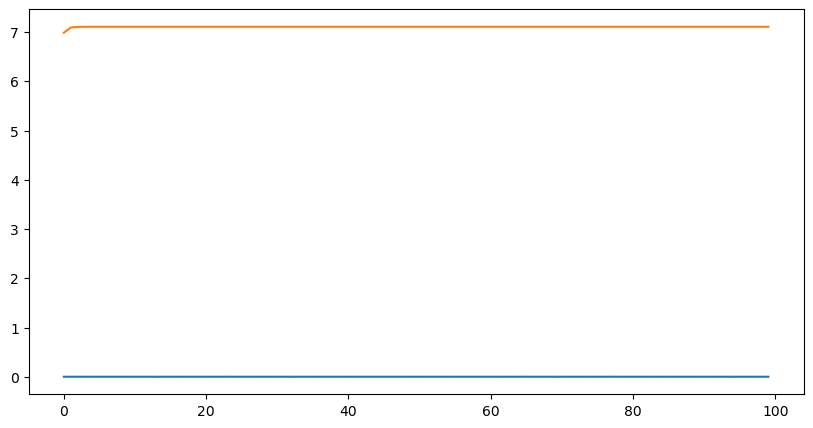

In [10]:

######### EXPERIMENTAL #########
######### EXPERIMENTAL #########
######### EXPERIMENTAL #########
## 9a) GARCH model to predict target volatility in 2nd 10 mins.

## multiply the log_returns by 10000 to avoid convergence warnings 
## are likely to occur in the case of very small numbers



train_df = book_wap_log_returns_df[book_wap_log_returns_df['row_id'] == '1-5'] # selec the first time_id of stock 1
continuous_time_id = np.arange(0, len(train_df)-100,1) # create continuous time_id for missing time_ids
train_df = train_df.reindex(continuous_time_id).ffill().bfill() 


plot_acf(train_df['log_return'])#.pow(2))
plot_pacf(train_df['log_return'])#.pow(2))

test_df = book_wap_log_returns_df.iloc[len(train_df):len(train_df)+100].reset_index(drop=True) # selec the first time_id of stock 1
continuous_time_id = np.arange(0, 100,1) # create continuous time_id for missing time_ids
test_df = test_df.reindex(continuous_time_id).ffill().bfill() 

plt.figure(figsize=(10, 5))
plt.plot(train_df['log_return'])
plt.plot(test_df['log_return'])
plt.show()


plt.figure(figsize=(10, 5))
plt.title(" instantaneous volatilities (Squared log returns)")
plt.plot(train_df['log_return'].pow(2))
plt.plot(test_df['log_return'].pow(2))
plt.show()


# define model
model = arch_model(train_df['log_return'], mean='Zero', vol='ARCH', p=1,rescale=True)

# fit model
model_fit = model.fit(disp="off")


# forecast the test set
yhat = model_fit.forecast(horizon=100)

model_fit.plot()
model_fit.summary()

plt.figure(figsize=(10, 5))
# plot the actual variance
plt.plot(test_df['log_return'])
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()

# bic_egarch = [] # grid-search best parameters for EGARCH model
# for p in range(1, 3):
#     for q in range(0, 3):
#         egarch = arch_model(temp_df['log_return_10000'], mean='AR',vol='GARCH',p=p, q=q).fit(disp='off')
#         bic_egarch.append(egarch.bic)
#         if egarch.bic == np.min(bic_egarch):
#             best_param = p, q
#             egarch = arch_model(temp_df['log_return_10000'], mean='AR', vol='GARCH', p=p,q=q).fit(disp='off')

# temp_df['log_return_10000'][560:].plot()
# forecast = egarch.forecast(horizon=2,start=temp_df.index[-10],method="analytical",reindex=False)
# forecast.variance.plot(title="Simulation forecasts for different horizons")



In [ ]:
"""
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
"""
# ## 7a) Check if minimum/maximum of bidsize1 and asksize1 in a time_id correlated with target realized volatitlity for the same time_id?

# # @jit(nopython=True)
# # def numba_correlations_df7a_e():
# columns = ['min_bid_price', 'max_bid_price', 'min_ask_price', 'max_ask_price','min_bid_size', 'max_bid_sizee', 'min_ask_size', 'max_ask_size', 'range_ask_price', 'range_bid_price', 'range_ask_size', 'range_bid_size']
# index = unique_stocks_id
# correlations_df7a_e = pd.DataFrame(columns=columns, index=index)
# correlations_df7a_e

# for st_id in unique_stocks_id:
#     # if st_id != 0: # select the stock to display here
#     #     break
#     st_min_bid_price = []
#     st_max_bid_price = []
#     st_min_ask_price = []
#     st_max_ask_price = []
#     st_range_ask_price = []
#     st_range_bid_price = []
#     st_range_ask_size = []
#     st_range_bid_size = []
#     book_train = pd.read_parquet(file+'.parquet/stock_id='+str(st_id)) #book_train or trade_train

#     for time_id in book_train['time_id'].unique():
#         min_bid_price = book_train[book_train['time_id'] == time_id][bid_price].min()
#         st_min_bid_price.append(min_bid_price)
#         max_bid_price = book_train[book_train['time_id'] == time_id][bid_price].max()
#         st_max_bid_price.append(max_bid_price)
#         min_ask_price = book_train[book_train['time_id'] == time_id][ask_price].min()
#         st_min_ask_price.append(min_ask_price)
#         max_ask_price = book_train[book_train['time_id'] == time_id][ask_price].max()
#         st_max_ask_price.append(max_ask_price)
#         st_range_ask_price.append(max_ask_price - min_ask_price)
#         st_range_bid_price.append(max_bid_price - min_bid_price)
#         min_ask_size = book_train[book_train['time_id'] == time_id][ask_size].min()
#         max_ask_size = book_train[book_train['time_id'] == time_id][ask_size].max()
#         st_range_ask_size.append(max_ask_size - min_ask_size)
#         min_bid_size = book_train[book_train['time_id'] == time_id][bid_size].min()
#         max_bid_size = book_train[book_train['time_id'] == time_id][bid_size].max()
#         st_range_bid_size.append(max_bid_size - min_bid_size)

#     correlations_df7a_e.loc[st_id,'min_bid_price'] = pd.Series(st_min_bid_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'max_bid_price'] = pd.Series(st_max_bid_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'min_ask_price'] = pd.Series(st_min_ask_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'max_ask_price'] = pd.Series(st_max_ask_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'range_ask_price'] = pd.Series(st_range_ask_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'range_bid_price'] = pd.Series(st_range_bid_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'range_ask_size'] = pd.Series(st_range_ask_size).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'range_bid_size'] = pd.Series(st_range_bid_size).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
        
# #     return correlations_df7a_e
# # correlations_df7a_e = numba_correlations_df7a_e()
# correlations_df7a_e.to_csv('correlations_df7a_e_'+file+'_lvl_'+level+'.csv')

'\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\n'

In [ ]:
"""
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
"""
# # @numba.jit(nopython=True)
# # def numba_sad(train:pd.DataFrame, unique_stocks_id, corr_method):
# columns = ['sad_ask_price', 'sad_ask_size', 'sad_bid_price', 'sad_bid_size']
# index = unique_stocks_id
# correlations_df7f = pd.DataFrame(columns=columns, index=index)
# correlations_df7f

# for st_id in unique_stocks_id:
#     # if st_id != 0: # select the stock to display here
#     #     break
#     st_sum_abs_dif_ask_price = []
#     st_sum_abs_dif_ask_size = []
#     st_sum_abs_dif_bid_price = []
#     st_sum_abs_dif_bid_size = []
#     book_train = pd.read_parquet(file+'.parquet/stock_id='+str(st_id))  #book_train or trade_train
    
#     for time_id in book_train['time_id'].unique():
#         sum_abs_dif_ask_price = book_train[book_train['time_id']==time_id][ask_price].diff().abs().sum() # 7f) check if the sum of absolute differences is correlated with target
#         st_sum_abs_dif_ask_price.append(sum_abs_dif_ask_price)
#         sum_abs_dif_ask_size = book_train[book_train['time_id']==time_id][ask_size].diff().abs().sum() # 7f) check if the sum of absolute differences is correlated with target
#         st_sum_abs_dif_ask_size.append(sum_abs_dif_ask_size)
#         sum_abs_dif_bid_price = book_train[book_train['time_id']==time_id][bid_price].diff().abs().sum() # 7f) check if the sum of absolute differences is correlated with target
#         st_sum_abs_dif_bid_price.append(sum_abs_dif_bid_price)
#         sum_abs_dif_bid_size = book_train[book_train['time_id']==time_id][bid_size].diff().abs().sum()
#         st_sum_abs_dif_bid_size.append(sum_abs_dif_bid_size)

#     correlations_df7f.loc[st_id,'sad_ask_price'] = pd.Series(st_sum_abs_dif_ask_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7f.loc[st_id,'sad_ask_size'] = pd.Series(st_sum_abs_dif_ask_size).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7f.loc[st_id,'sad_bid_price'] = pd.Series(st_sum_abs_dif_bid_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method) 
#     correlations_df7f.loc[st_id,'sad_bid_size'] = pd.Series(st_sum_abs_dif_bid_size).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)

# #     return correlations_df7f
# # correlations_df7f = numba_sad(train=train, unique_stocks_id=unique_stocks_id, corr_method=corr_method)
# correlations_df7f.to_csv('correlations_df7f_'+file+'_lvl_'+level+'.csv')

'\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\n'

In [ ]:
# ## single stock book data 
# ## check how prices are distributed in the book data so that we can see how log(s_t2/s_t1) transformation of prices below and above 1 affects volatitliy.
""" ## THE RESULTS ARE ALREADY DOCUMENTED IN IDEAS """
# st_min_bid_price = []
# st_max_bid_price = []
# st_min_ask_price = []
# st_max_ask_price = []

# for st_id in unique_stocks_id:

#     book_train = pd.read_parquet('book_train.parquet/stock_id='+str(st_id))
#     st_min_bid_price.append(book_train["bid_price1"].min())
#     st_max_bid_price.append(book_train["bid_price1"].max())
#     st_min_ask_price.append(book_train["ask_price1"].min())
#     st_max_ask_price.append(book_train["ask_price1"].max())
#     if st_id != 1: # selec the stock to display here
#         continue
#     select_id = st_id
#     print(book_train["bid_price1"].max())
#     print(book_train["bid_price1"].min())

# all_st_min_ask_price = np.min(np.array(st_min_ask_price))
# all_st_max_ask_price = np.min(np.array(st_max_ask_price))
# all_st_min_bid_price = np.min(np.array(st_min_bid_price))
# all_st_max_bid_price = np.min(np.array(st_max_bid_price))

# print(f'min ask price in all stocks: {all_st_min_ask_price}')
# print(f'max ask price in all stocks: {all_st_max_ask_price}')
# print(f'min bid price in all stocks: {all_st_min_bid_price}')
# print(f'max bid price in all stocks: {all_st_max_bid_price}')


# print('stock id '+str(select_id))
# book_train

' ## THE RESULTS ARE ALREADY DOCUMENTED IN IDEAS '

In [ ]:
# ## due to log nature check if non-linearity is visible
# ## Non-linearity is NOT visible as variance in price is low. so NO need to treat prices < 1 differently from prices > 1.
""" ## THE RESULTS ARE ALREADY DOCUMENTED IN IDEAS """
# plt.figure()
# plt.plot(np.arange(all_st_min_bid_price,all_st_max_bid_price,0.0001),np.log(np.arange(all_st_min_bid_price,all_st_max_bid_price,0.0001)),)
# plt.title("log of all_st_min_bid_price to all_st_max_bid_price")
# plt.grid()
# plt.show()

# plt.figure()
# plt.plot(np.arange(all_st_min_ask_price,all_st_max_ask_price,0.0001),np.log(np.arange(all_st_min_ask_price,all_st_max_ask_price,0.0001)),)
# plt.title("log of all_st_min_ask_price to all_st_max_ask_price")
# plt.grid()
# plt.show()

' ## THE RESULTS ARE ALREADY DOCUMENTED IN IDEAS '

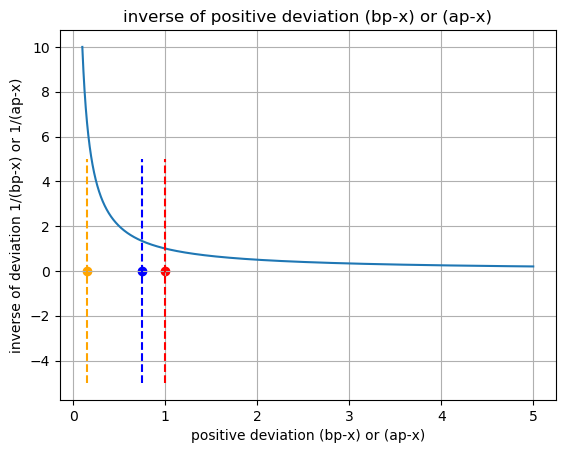

In [42]:
plt.plot(np.arange(0.1,5,0.001),1/(np.arange(0.1,5,0.001)),)
# plt.hlines(y=0,xmin=0,xmax=5,colors='r')
plt.vlines(x=1,ymin=-5,ymax=5,linestyles='dashed',colors='r')
plt.vlines(x=0.75,ymin=-5,ymax=5,linestyles='dashed',colors='b')
plt.vlines(x=0.15,ymin=-5,ymax=5,linestyles='dashed',colors='orange')
plt.xlabel('positive deviation (bp-x) or (ap-x)')
plt.ylabel('inverse of deviation 1/(bp-x) or 1/(ap-x)')
plt.title("inverse of positive deviation (bp-x) or (ap-x)")
plt.scatter(1, np.log(1), color='red', marker='o', label='Marker')
plt.scatter(0.75, np.log(1), color='blue', marker='o', label='Marker')
plt.scatter(0.15, np.log(1), color='orange', marker='o', label='Marker')
plt.grid()
plt.show()